In [1]:
# IMPORTING LIBRARIES

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


In [2]:
# models

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
#for performance evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [4]:
# IMPORTING LIBRARIES

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10

Attribute Information:

* Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

**Objective: Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).**


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# 1. DATA READING

In [5]:
# READING THE DATA

df=pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")

In [6]:
df.head(2)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [7]:
# Size of dataset

uncleaned_df_shape=df.shape
uncleaned_df_shape

(568454, 10)

In [8]:
# Getting count of review type for entire data

Score=df['Score'].value_counts()
Score

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

Text(0, 0.5, 'Number of reviews')

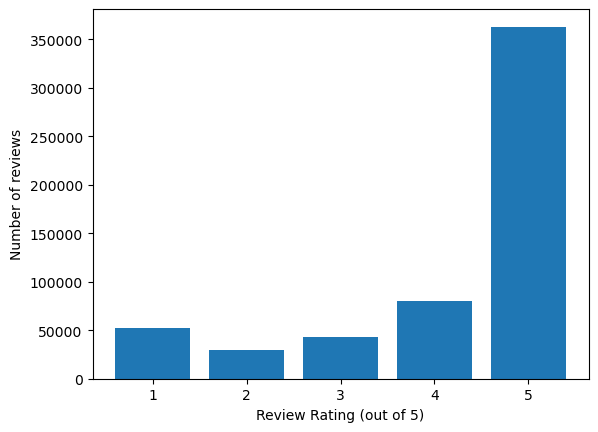

In [9]:
# Visualizing the data

y=Score.values
x=Score.index
plt.bar(x,y)
plt.xlabel('Review Rating (out of 5)')
plt.ylabel('Number of reviews')


* From the above bar graph, it is evident that maximum people have given 5 star rating for various products
* This will lead to imbalanced dataset

# 2. DATA CLEANING

## 2.1 REMOVING NULL VALUES

In [10]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [11]:
#  Dropping the  rows from df where any of the values are missing or NaN.

df.dropna(axis=0,how='any',inplace=True)  # axis=0 for row wise elimination
df.shape

(568411, 10)

## 2.2 REMOVING DUPLICATE VALUES

In [12]:
# FINDING DUPLICATED VALUES

df[df.duplicated(['UserId','ProfileName','Score','Time'])]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
426,427,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,4,1334016000,"pretty good, could be better",Glad to find these in a one ounce size but the...
467,468,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,0,0,5,1231718400,"Crunchy, salty, sweet...finally, a Superbowl s...",These Honey Dijon chips bring a terrific balan...
486,487,B000G6RYNE,A31N6KB160O508,Fran W.,0,0,4,1214006400,Firm quality chip,Just got this order and it is ok. A bit light ...
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
...,...,...,...,...,...,...,...,...,...,...
568411,568412,B0018CLWM4,AUX1HSY8FX55S,DAW,1,1,5,1319500800,Happy Camper,I bought this to try on two registered Maine C...
568412,568413,B0018CLWM4,AVZ2OZ479Q9E8,Ai Ling Chow,0,0,5,1336435200,Two Siberians like it!,When we brought home two 3-month-old purebred ...
568413,568414,B0018CLWM4,AI3Y26HLPYW4L,kimosabe,1,2,2,1330041600,premium edge cat food,My cats don't like it. what else can I say to ...
568440,568441,B005ZC0RRO,A2TO5R8QLIITEF,SAK,1,1,5,1323734400,"Delicious, all natural and allergy free treats!",Indie Candy's gummies are absolutely delicious...


In [13]:
# DROPPING DUPLICATES

df.drop_duplicates(inplace=True, subset=['UserId','ProfileName','Score','Time'] , keep ="first")
df.shape

(368079, 10)

Final check for null values


In [14]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

## 2.3  REMOVING ROWS WITH HELPFULLNESS NUMERATOR GREATER THAN HELPFULLNESS DENOMINATOR

It is seen that in two rows of the dataset, the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [15]:
df=df[df['HelpfulnessNumerator']<=df['HelpfulnessDenominator']]

In [16]:
# FINAL SHAPE OF DATA AFTER DATA CLEANING
df.shape

(368077, 10)

In [17]:
# Creating a functionto give  reviews with Score>3 a positive rating ( 1 )
#and reviews with a score<3 a negative rating ( 0 ).
def partition(x):
    if x < 3:
        return 0
    return 1

# * 1= Positive Review
# * 0= Negative Review

In [18]:
#changing reviews with score less than 3 to be positive and vice-versa

actualScore = df['Score']
positiveNegative = actualScore.map(partition) 
df['Score'] = positiveNegative
print("Number of data points in our data", df.shape)
df.head(3)
# type(positiveNegative)

Number of data points in our data (368077, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Text(0, 0.5, 'Number of reviews')

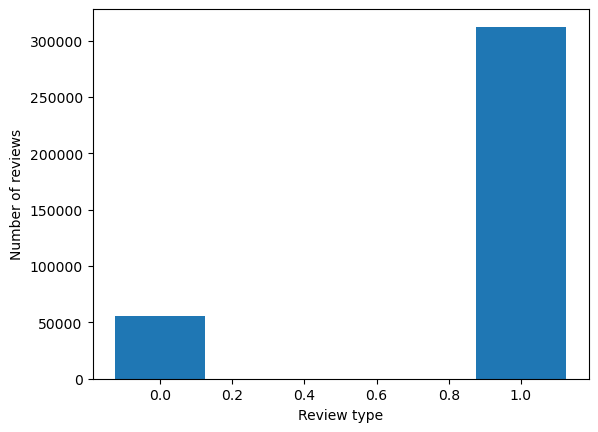

In [19]:
sentiment=df['Score'].value_counts()
sentiment
plt.bar(sentiment.index,sentiment.values,width=0.25)
plt.xlabel('Review type')
plt.ylabel('Number of reviews')

In [20]:
sentiment.count()

2

In [21]:
#df1 will be used with class imbalance

df1 = df.copy()

In [22]:
df['Score'].value_counts()

1    312340
0     55737
Name: Score, dtype: int64

In [23]:
# Randomly selecting 50000 reviews from each of positive and negative set of reviews
  
positive=df.loc[df['Score']==1].sample(50000) # randomly selects 50000 reviews from positive reviews
negative=df.loc[df['Score']==0].sample(50000) # randomly selects 50000 reviews from negative reviews
df=pd.concat([positive,negative])
df.shape
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# 3 TEXT PREPROCESSING

Now that we have finished data cleaning, our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (**as it was researched that there is no adjective in 2-letters**)
5. Convert the word to **lowercase**
6. **Remove Stopwords**
7. Finally Snowball **Stemming the word** (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

## 3.1 REMOVING html TAGS FROM THE TEXT

In [24]:
# printing some random reviews to see how reviews have been written

sent_0 = df['Text'].values[0]
print(sent_0)


The BEST frozen pops I've found, and I think I've tried all that Amazon has to offer plus all the brands carried in my local supermarket.<br /><br />The flavors are bright and refreshing, not overly sweet, and totally recognizable. Too many pops end up tasting like frozen sugar water, with little or no fruit flavor. Not these. The lemon tastes like frozen lemonade; the strawberry tastes like frozen strawberries without the seeds.<br /><br />I've looked for these locally, but no one has them. Glad they're offered on Amazon, even if they are pricey.


In [25]:
# # Removing urls from text: https://stackoverflow.com/a/40823105/4084039

# sent_0 = re.sub(r"http\S+", "", sent_0)
# print(sent_0)

In [26]:
# Function to remove html tags from the text

def clean_html_tags(sentence): 
    
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, '', sentence)
    return cleantext

In [27]:
from bs4 import BeautifulSoup
# from tqdm import tqdm
# preprocessed_reviews = []
# for snt in tqdm(final_df['Text'].values):
#     snt = re.sub(r"http\S+", "", snt)
#     snt = BeautifulSoup(snt, 'lxml').get_text()
#     snt = decontracted(snt)
#     snt = re.sub("\S*\d\S*", "", snt)
#     snt = re.sub('[^A-Za-z0-9]', " ", snt)
#     snt = ' '.join(e.lower() for e in snt.split() if e.lower() not in final_stopwords)
#     preprocessed_reviews.append(snt)


In [28]:
# # Removing tags
# # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
# from bs4 import BeautifulSoup

# soup = BeautifulSoup(sent_0, 'lxml')
# text = soup.get_text()
# print(text)

## 3.2 REMOVING PUNCTUATION MARKS OR SPECIAL CHARACTERS 

In [29]:
# Function to remove any punctuation mark or special character

def clean_punc(sentence): 
    cleaned = re.sub(r'[?|!|\|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

## 3.3 DECONTRACTING WORDS

In [30]:
# def decontracted(phrase):
#     # specific
#     phrase = re.sub(r"won't", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
#     return phrase

## 3.4  STOP WORDS 

In [31]:
#from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
total_stopwords = set(stopwords.words('english'))
#print(total_stopwords)

In [33]:
# Subtracting negative stop words from the total stop words

negative_stopwords=set(word for word in total_stopwords if "n't"in word or "n'"in word or "no"in word)
#negative_stopwords
final_stopwords = total_stopwords - negative_stopwords
print(final_stopwords)

{'our', 'he', 'weren', 'had', 'of', 'that', 'too', 'won', 'from', 're', "it's", "she's", 'themselves', 'has', 'again', 'during', 'so', 'because', 'being', 'ma', 'myself', 'about', 'its', 'further', 'at', 'is', 'will', 'very', 's', 'own', 'out', 'whom', 'ourselves', 'hasn', 'she', 'on', 'can', 'me', 'few', "that'll", 'll', 'himself', 'am', 'if', 'down', 'needn', 'wasn', 'did', 'his', 'against', 'don', 'which', 'are', 'more', 'those', 'what', 'over', 'just', 'with', 'this', 'there', 'i', 'should', 'm', 'my', 'their', 'him', 'why', 'doing', 'mightn', 'once', 'having', 'couldn', 'your', 'any', 'they', 'itself', 't', 'them', 'below', 'each', 'while', 'up', 'both', 'hers', 'these', 'd', 'the', 'under', 'than', 'her', 'where', 'before', 'such', 'aren', 'after', "you're", 'was', 'isn', 'between', 'same', 'yourself', 'were', 'other', 'an', 'be', 'by', 'who', 'we', 'ours', 'do', 'and', 'haven', 'until', 'as', 'or', "should've", 'been', 'into', 'hadn', 'some', 'then', 'doesn', 'mustn', 'most', 't

## 3.5  STEMMING

In [34]:
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer(language='english')

# word = 'running'
# stem = stemmer.stem(word)

# TEXT SUMMARIZATION
## *APPLYING ALL TEXT PRE-PROCESSING TO THE TEXT COLUMN IN OUR DATAFRAME*

In [35]:
def final_sentence(text):
    
    text = text.split()
#     text = [decontracted(x) for x in text]
    text = [re.sub(r"http\S+", "", x) for x in text]
    text = [BeautifulSoup(x, 'lxml').get_text() for x in text]
    #text = [clean_html_tags(x) for x in text]
    text = [clean_punc(x) for x in text]
    
    
    def test(word):
        if word.isalpha() and len(word) > 2 and word.lower() not in final_stopwords:
            s=(stemmer.stem(word.lower()))
            return s
        else:
            pass
    text = [test(x) for x in text if test(x)]
    
    return ' '.join(text)
                
    

In [36]:
# Apllying all the text processing to text column of our dataframe

from tqdm import tqdm
tqdm.pandas()

df['CleanedText'] = (df['Text']+df['Summary']).progress_apply(final_sentence)
#df1['CleanedText'] = df1['Text'].progress_apply(final_sentence)
print(df.shape)

100%|██████████| 100000/100000 [30:15<00:00, 55.08it/s]

(100000, 11)


### We will concatenate summary column and text column and then apply all pre-processing on the new concatenated column.
### So, the final column named 'CleanedText' will have the required pre=processed text

In [37]:
print(df['CleanedText'].values[0])
print("---------------------------------------------------------------------------------")
print(df['Text'].values[0])

best frozen pop think tri amazon offer plus brand carri local flavor bright not over total mani pop end tast like frozen sugar littl fruit not lemon tast like frozen strawberri tast like frozen strawberri without look one glad offer even flavor
---------------------------------------------------------------------------------
The BEST frozen pops I've found, and I think I've tried all that Amazon has to offer plus all the brands carried in my local supermarket.<br /><br />The flavors are bright and refreshing, not overly sweet, and totally recognizable. Too many pops end up tasting like frozen sugar water, with little or no fruit flavor. Not these. The lemon tastes like frozen lemonade; the strawberry tastes like frozen strawberries without the seeds.<br /><br />I've looked for these locally, but no one has them. Glad they're offered on Amazon, even if they are pricey.


# VISUALIZATION USING WORDCLOUD

In [38]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [39]:
from wordcloud import WordCloud, STOPWORDS

In [40]:
def generate_wcloud(text):
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate(text)
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

In [41]:
df.shape

(100000, 11)

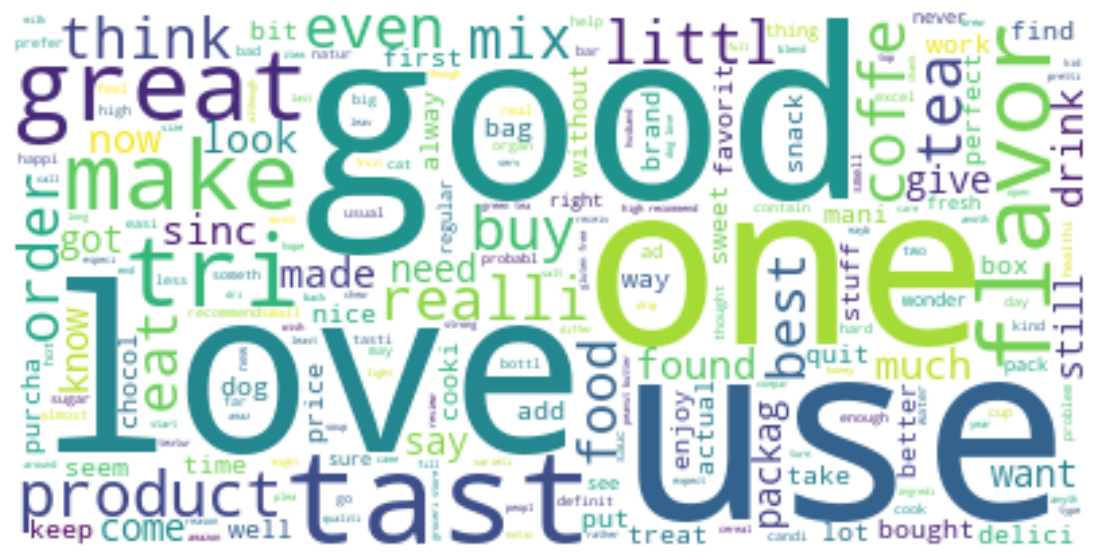

In [103]:
# WORDCLOUD FOR POSITIVE SENTIMENTS

pos = df.loc[df.Score==1].CleanedText
text = " ".join(review for review in pos.astype(str))
generate_wcloud(text)

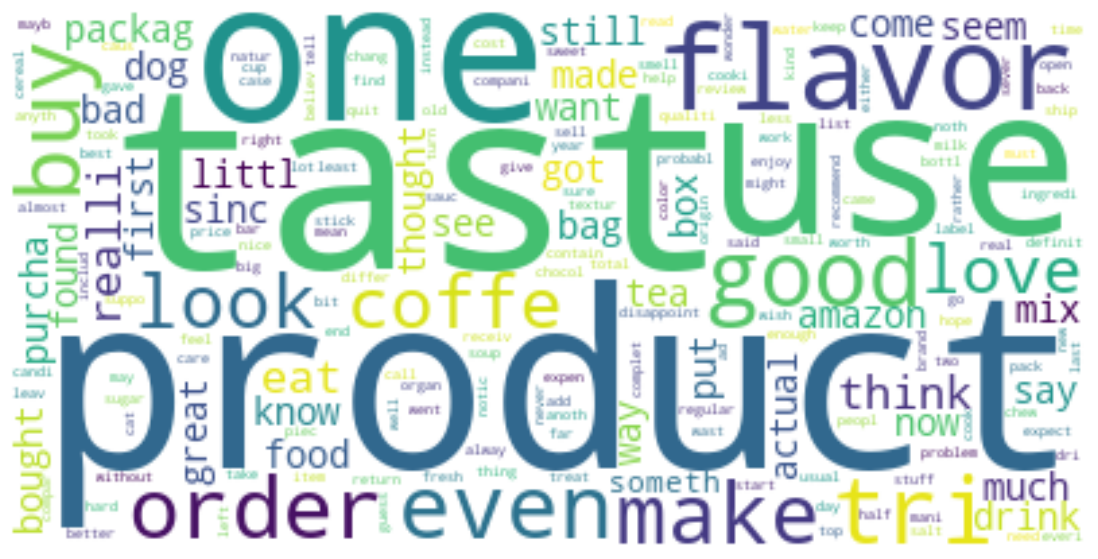

In [104]:
# WORDCLOUD FOR NEGATIVE SENTIMENTS

neg = df.loc[df.Score==0].CleanedText
text = " ".join(review for review in neg.astype(str))
generate_wcloud(text)

# MODEL BUILDING


In [44]:
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
136261,136262,B002GOZ43G,A2MNB77YGJ3CN0,L. Mountford,0,0,1,1348444800,Super flavor ...,"The BEST frozen pops I've found, and I think I...",best frozen pop think tri amazon offer plus br...


# To avoid data leakage, first split the data into train and test, 

# then build BOW or TF-IDF on only training dataset and not on complete dataset 

In [45]:
# SPLITTING THE DATA INTO TRAINING AND TESTING 

from sklearn.model_selection import train_test_split
#X = df.CleanedText
#y = df.Score

X1 = df.CleanedText
y1 = df.Score


In [46]:
type(X1)

pandas.core.series.Series

In [47]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20)

In [48]:
print(X1_train.shape)
print(X1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(80000,)
(20000,)
(80000,)
(20000,)


In [49]:
y1_train.value_counts()

0    40107
1    39893
Name: Score, dtype: int64

In [50]:
y1_test = pd.DataFrame(y1_test)

In [51]:
y1_test.value_counts()

Score
1        10107
0         9893
dtype: int64

In [52]:
y1_train = pd.DataFrame(y1_train)

In [53]:
y1_train.value_counts()

Score
0        40107
1        39893
dtype: int64

In [54]:
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
# from imblearn.under_sampling import (RandomUnderSampler, 
#                                     NearMiss, 
#                                     InstanceHardnessThreshold,
#                                     CondensedNearestNeighbour,
#                                     EditedNearestNeighbours,
#                                     RepeatedEditedNearestNeighbours,
#                                     AllKNN,
#                                     NeighbourhoodCleaningRule,
#                                     OneSidedSelection,
#                                     TomekLinks)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline

# RESUME****

The reason for fitting only on the training data and transforming both the training and test data using the same CountVectorizer instance is to ensure consistency in the vocabulary and tokenization across the datasets. Here's why:

Vocabulary consistency: The CountVectorizer learns the vocabulary (unique tokens) from the training data during the fitting process. It assigns each unique token an index in its internal vocabulary. When you fit the CountVectorizer on the training data, it builds the vocabulary based on the tokens in the training set.

Generalization to unseen data: Once the CountVectorizer has learned the vocabulary from the training data, it can be applied to transform any new text data, including the test data. The purpose of transforming the test data is to represent it in the same way as the training data, ensuring consistency in tokenization and representing the text as a matrix of token counts.

By fitting the CountVectorizer only on the training data, you ensure that the vocabulary is learned from the training set alone. This prevents any leakage of information from the test set into the training process, which could result in over-optimistic performance estimates.

To summarize, fitting the CountVectorizer only on the training data and then transforming both the training and test data with the same vectorizer instance ensures that the tokenization and vocabulary are consistent across the datasets, enabling fair evaluation of the model's performance on unseen data.

## IMPLEMENTING BAG OF WORDS

In [55]:

# Implementing Bag Of Words

count_vect1= CountVectorizer(max_features=10000)
count_vect1.fit(X1_train) #.fit_transform() on training data and only transform on test data

# transformation
bow_X1_train = count_vect1.transform(X1_train)
bow_X1_test = count_vect1.transform(X1_test)


# count_vect1 = CountVectorizer(max_features=10000)
#count_vect.fit(X_train)

#bow_X_train = bow_vectorizer.transform(X_train)
#bow_X_test = bow_vectorizer.transform(X_test)



In [56]:
print(y1_train.value_counts())
# print("-"*100)
# print(bow_X1_train.shape)


Score
0        40107
1        39893
dtype: int64


### As we can see that class 0 counts are 40060 and class1 counts are 39940, which is unbalanced dataset, so we do SMOTE on training data 

In [57]:
#SMOTE on Training data only with BOW
sm = SMOTE(sampling_strategy='minority')
sm_xtrain_bow, sm_train_y_bow = sm.fit_resample(bow_X1_train, y1_train)

In [58]:
print(sm_xtrain_bow.shape)
print('-'*100)
print(sm_train_y_bow.shape)
print('-'*100)
print(sm_train_y_bow.value_counts())

(80214, 10000)
----------------------------------------------------------------------------------------------------
(80214, 1)
----------------------------------------------------------------------------------------------------
Score
0        40107
1        40107
dtype: int64


## IMPLEMENTING TF-IDF

In [59]:
# tf-idf

# transformation using tf-idf
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X1_train)

# transform
#tfidf_X_train = tfidf_vectorizer.transform(X_train)
#tfidf_X_test = tfidf_vectorizer.transform(X_test)
tfidf_X1_train = tfidf_vectorizer.transform(X1_train)
tfidf_X1_test = tfidf_vectorizer.transform(X1_test)

In [60]:
#SMOTE on Training data only for tf-idf

sm = SMOTE(sampling_strategy='minority')
sm_xtrain_tfidf, sm_train_y = sm.fit_resample(tfidf_X1_train, y1_train)

In [61]:
sm_train_y.value_counts()

Score
0        40107
1        40107
dtype: int64

### FOR BOW:
* #### TRAINING DATA = sm_xtrain_bow , sm_xtrain_bow
* #### TEST DATA = bow_X1_test , y1_test

### FOR TF-IDF:
* #### TRAINING DATA = sm_xtrain_tfidf,sm_train_y
* #### TEST DATA = tfidf_X1_test , y1_test

In [62]:
# Defining model for future

def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(trainY, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(testY, y_preds_test)}")
    print(classification_report(testY, y_preds_test))
    print('\n',40*'-')

 # 1.1 LOGISTIC REGRESSION WITH BOW

In [63]:
#Logistic regression with GridsearchCV with BOW
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
# parameter grid
parameters = {
    'penalty' : ['l2'], 
    'C'       : [0.001, 0.01, 0.1, 1, 10],
    'solver'  : [ 'lbfgs'],
}

In [64]:
logreg = LogisticRegression()
clf_lrbow1 = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [65]:
clf_lrbow1.fit(sm_xtrain_bow, sm_train_y_bow)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy')

In [66]:
print("Tuned Hyperparameters :", clf_lrbow1.best_params_)
print("Accuracy :",clf_lrbow1.best_score_)

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.8443039666723766


In [67]:
y_pred_bow = clf_lrbow1.predict(bow_X1_test)

In [68]:
from sklearn.metrics import classification_report
print(classification_report(y1_test, y_pred_bow))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      9893
           1       0.85      0.85      0.85     10107

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000



In [69]:
# ### Cross Validation logistic regression with Bow
# a = np.random.normal(loc = 0 , scale = 0.1,size = 50)
# param_distb =  {'C': [b for b in a if b >0  ]}
# print(param_distb)

In [70]:
# def plot_cm(y_true, y_pred):
#     plt.figure(figsize=(6,6))
    
#     cm = confusion_matrix(y_true, y_pred, normalize='true')
    
#     sns.heatmap(
#         cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
#         xticklabels= labels, yticklabels= labels)
    
#     return plt.show()

In [71]:
# plot_cm(y1_test, y_pred_bow)

# 1.2 LOGISTIC REGRESSION WITH TF-IDF


In [72]:
#Logistic regression with GridsearchCV with TF-IDF
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
# parameter grid
parameters = {
    'penalty' : ['l2'], 
    'C'       : [0.001, 0.01, 0.1, 1, 10],
    'solver'  : [ 'lbfgs'],
}



In [73]:
logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [74]:
clf.fit(sm_xtrain_tfidf,sm_train_y)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy')

In [75]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.8474954270345751


In [76]:
y_pred = clf.predict(tfidf_X1_test)

In [77]:
from sklearn.metrics import classification_report
print(classification_report(y1_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      9893
           1       0.86      0.84      0.85     10107

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000



# Word2Vec

## IMPLEMENTING Word2Vec

In [78]:
from gensim.models import Word2Vec

In [79]:
#Creating our own word to vec model using gensim library.

sentences = [nltk.word_tokenize(sentence) for sentence in X1_train]  # sentences is a list of tokenized words in training data

for i in range(len(sentences)):
    sentences[i] = [word for word in sentences[i] if word not in final_stopwords]

In [80]:
print(type(sentences), len(sentences), sentences[89])

<class 'list'> 80000 ['love', 'fruit', 'juic', 'love', 'carbon', 'beverag', 'realli', 'expect', 'love', 'not', 'first', 'portion', 'size', 'diminu', 'comparison', 'drink', 'not', 'find', 'tast', 'tast', 'like', 'black', 'cherri', 'harsh', 'flavor', 'strong', 'aftertast', 'carbon', 'mild', 'almost', 'tast', 'review', 'point', 'relat', 'high', 'calor', 'content', 'even', 'without', 'ad', 'addit', 'great', 'contain', 'full', 'day', 'suppli', 'vitamin', 'not', 'justifi', 'cost', 'product', 'weird', 'bubbl', 'fruit', 'juic']


In [81]:
# Creating our own Word2Vec model from the gensim library to train word embeddings on the tokenized sentences.

w2v_model = Word2Vec(sentences,min_count = 1,vector_size=100) 

#The "min_count" parameter is set to 1. This parameter specifies the minimum frequency threshold for words to be included 
#in the word embeddings. In this case, all words present in the training data will be considered for embedding creation, 
#regardless of their frequency.

In [82]:
# getting generated vector for word 'sad'
vector = w2v_model.wv['sad']
print(vector)
vector.shape

[ 0.32444495  0.07753262 -0.42109933  0.1999681  -0.5153469  -0.17253615
 -0.1573234   0.5501877  -0.6331048  -0.180243   -0.16137253 -0.11057661
  0.17563325  0.4166387   0.05330966 -0.12205829  0.34001744 -0.27378738
  0.10841024 -0.13560152 -0.50285524  0.01385837  0.42864698  0.33620808
  0.07480971 -0.1232468   0.03536448  0.5004797   0.38065973 -0.27059054
  0.8340798   0.23817484  0.42192462 -0.10923546 -0.33454627  0.42112345
 -0.5131708   0.10361244  0.2318017  -0.54695874  0.03276006  0.07309277
 -0.23109369  0.162873    0.3303687   0.1290104  -0.18782574 -0.2229666
  0.37878418  0.05953212  0.11881419 -0.2639915  -0.50985533 -0.20330086
 -0.17488629  0.10684619 -0.7179255  -0.11204094 -0.02117162  0.4671278
  0.03945135 -1.097455    0.8190686   0.0819651  -0.06445381 -0.00256143
 -0.22512706 -0.03646002 -0.52648443  0.4433599   0.65857226 -0.06385771
 -0.8620321  -0.31781217  0.66389835 -1.0586444  -0.49019435 -0.3655105
  0.02724189  0.53099245 -0.3914509   0.41265398 -0.32

(100,)

In [83]:
# Getting words similar to a given word from the corpus

similar = w2v_model.wv.most_similar('bad')
similar

[('terribl', 0.7030547261238098),
 ('aw', 0.6884288787841797),
 ('horribl', 0.6857085227966309),
 ('gross', 0.6467927694320679),
 ('weird', 0.6308580040931702),
 ('funni', 0.6149153709411621),
 ('bother', 0.5731919407844543),
 ('nasti', 0.5707023739814758),
 ('somehow', 0.564603328704834),
 ('mayb', 0.5627135634422302)]

In [84]:
# # average Word2Vec

# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sentences): # for each review/sentence
    i=1
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in sentences[i]:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
            
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    i+=1
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 80000/80000 [00:04<00:00, 17161.66it/s]

80000
100


In [85]:
#sent_vectors[185]
len(sent_vectors)

80000

In [86]:
# Convert list to pandas Series

#X_w2v = pd.Series(sent_vectors)

In [87]:
type(y1_train)

pandas.core.frame.DataFrame

In [88]:
# Split the data into training and testing sets

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(sent_vectors, y1_train, test_size=0.2, random_state=42)

In [89]:
type(X_train_w2v)

list

In [90]:
# #SMOTE on Training data only for word 2 vec

# sm = SMOTE(sampling_strategy='minority')
# sm_xtrain_w2v, sm_train_y = sm.fit_resample(X_train_w2v, y1_train)

## LOGISTIC REGRESSION USING Word2Vec

In [91]:
#Logistic regression with GridsearchCV with TF-IDF
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
# parameter grid
parameters = {
    'penalty' : ['l2'], 
    'C'       : [0.001, 0.01, 0.1, 1, 10,100,1000],
    'solver'  : [ 'lbfgs'],
}

#The 'solver' parameter of LogisticRegression must be a str among {'lbfgs', 'newton-cg', 'newton-cholesky', 'saga', 'liblinear', 'sag'}.

In [92]:
logreg_w2v = LogisticRegression()
clf = GridSearchCV(logreg_w2v,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)  

In [93]:
clf.fit(X_train_w2v, y_train_w2v)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             scoring='accuracy')

In [94]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.6306406250000001


In [95]:
y_pred = clf.predict(X_test_w2v)

In [96]:
from sklearn.metrics import classification_report
print(classification_report(y_test_w2v, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.69      0.65      7942
           1       0.65      0.56      0.60      8058

    accuracy                           0.63     16000
   macro avg       0.63      0.63      0.63     16000
weighted avg       0.63      0.63      0.63     16000



## 2.1 NAIVE BAYES (NB) WITH BOW

In [97]:
alphas = [9.3]
for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=sm_xtrain_bow,
                   trainY=sm_train_y_bow,
                   testX=bow_X1_test,
                   testY=y1_test)


MultinomialNB(alpha=9.3)
Train accuracy score : 0.8394419926696088
Test accuracy score : 0.83005
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      9893
           1       0.83      0.84      0.83     10107

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000


 ----------------------------------------


## 2.2 NAIVE BAYES (NB) WITH TF-IDF

In [98]:
alphas = [9,9.05]
for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X1_train,
                   trainY=y1_train,
                   testX=tfidf_X1_test,
                   testY=y1_test)


MultinomialNB(alpha=9)
Train accuracy score : 0.8400375
Test accuracy score : 0.8285
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      9893
           1       0.83      0.82      0.83     10107

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000


 ----------------------------------------

MultinomialNB(alpha=9.05)
Train accuracy score : 0.84005
Test accuracy score : 0.8285
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      9893
           1       0.83      0.82      0.83     10107

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000


 ----------------------------------------


## 2.3 NAIVE BAYES (NB) WITH Word2Vec

### The Multinomial Naive Bayes algorithm is typically used for classification tasks with discrete features. It assumes that the input features are counts or frequencies, and therefore, it is not suitable for handling negative values directly.


In [99]:

# alphas = [9,9.05]
# for a  in alphas: 
#     # Define model
#     nb_model = MultinomialNB(alpha=a)

#     # Train and evaluate model
#     train_and_eval(model=nb_model,
#                    trainX=X_train_w2v,
#                    trainY=y_train_w2v,
#                    testX=X_test_w2v,
#                    testY=y1_test)

## 3.1 RANDOM FOREST with BOW

In [100]:
# Creating the Random Forest classifier object
clf = RandomForestClassifier(n_estimators=150, random_state=42)

# Training the classifier on the training data
clf.fit(sm_xtrain_bow, sm_train_y_bow)

# Predicting the target variable for the test data
y_pred_rf_bow = clf.predict(bow_X1_test)

# Evaluating the model's accuracy
accuracy = accuracy_score(y1_test, y_pred_rf_bow)
print("Accuracy:", accuracy)

Accuracy: 0.8296


## 3.2 RANDOM FOREST with TFIDF

In [101]:
# Creating the Random Forest classifier object
clf = RandomForestClassifier(n_estimators=150, random_state=42)

# Training the classifier on the training data
clf.fit(sm_xtrain_tfidf,sm_train_y)

# Predicting the target variable for the test data
y_pred_rf_tfidf = clf.predict(bow_X1_test)

# Evaluating the model's accuracy
accuracy = accuracy_score(y1_test, y_pred_rf_tfidf)
print("Accuracy:", accuracy)

Accuracy: 0.8018


## 4.1 SVM with BOW 

In [102]:
# from sklearn import svm
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Create an SVM classifier with a linear kernel
# svm_classifier = svm.SVC(kernel='linear')

# # Train the SVM classifier

# svm_classifier.fit(sm_xtrain_bow, sm_train_y_bow)

# # Make predictions on the test set
# y_pred_svm_bow = svm_classifier.predict(bow_X1_test)

# # Evaluate the accuracy of the classifier
# accuracy = accuracy_score(y1_test, y_pred_svm_bow)
# print("Accuracy:", accuracy)
